In [1]:
import pdal
pdal.__version__
import json
import pandas as pd
import numpy as np
import pdal
from pathlib import Path # KW_dense_cloud-22-58.las
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from osgeo import gdal
import rasterio
import rioxarray as rxr
from rasterio.features import shapes

In [2]:
pdal.__version__

'3.4.5'

In [3]:
def get_bin_statistics(array, length=1):
    df = pd.DataFrame(array)
    metadata = {
        "bin_x": np.floor(df.loc[:,"X"].min())+length/2,
        "bin_y": np.floor(df.loc[:,"Y"].min())+length/2,
        "bin_count": len(array),
        "bin_conf_sum": df.loc[:,"confidence"].sum()
    }
    
    return pd.DataFrame([metadata])

def get_bin_statistics_without_conf(array, length=1):
    df = pd.DataFrame(array)
    metadata = {
        "bin_x": np.floor(df.loc[:,"X"].min())+length/2,
        "bin_y": np.floor(df.loc[:,"Y"].min())+length/2,
        "bin_count": len(array)
        #"bin_conf_sum": df.loc[:,"Confidence"].sum()
    }
    
    return pd.DataFrame([metadata])

In [4]:
dc_data = Path(r"P:\Korttid\pbm\Err+Calderas\point_cloud")

P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-0.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-1.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-10.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-11.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-12.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-13.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-14.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-15.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-16.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-17.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-18.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-19.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-2.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-20.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-21.las
P:\Korttid\pbm\Err+Calderas\point_cloud\point_cloud-0-22.las
P:\Korttid\pbm\Err+Calderas

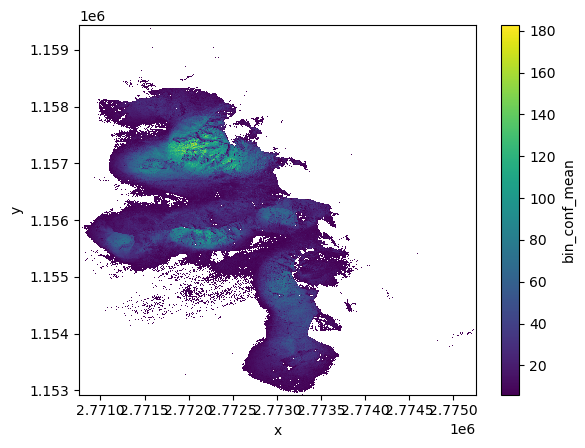

In [5]:
data = dc_data
for file_name in ["point_cloud-*-*.las"]:
    output = pd.DataFrame()
    for path in [i for i in data.glob(file_name)]:
        print(path)
        args = [
                {
                    "type" : "readers.las",
                    "filename" : f"{str(Path(data,path.name))}",
    #                "in_srs" : "EPSG:2056",
                    "extra_dims" : ["confidence=uint8", "normal=uint8"] # for dense cloud
                },
                {
                    "type":"filters.splitter",
                    "length":"1",
                    "origin_x":"2600000.0",
                    "origin_y":"1200000.0"
                }
            ]

        pipeline = pdal.Pipeline(json.dumps(args))
        count = pipeline.execute()
        arrays = pipeline.arrays
        metadata = pipeline.metadata
        log = pipeline.log
        for array in arrays:
            output = pd.concat([output, get_bin_statistics(array)], ignore_index=True)
            
    compiled_output = output.groupby(["bin_x","bin_y"]).sum().reset_index()
    compiled_output
    compiled_output["bin_conf_mean"] = compiled_output.bin_conf_sum/compiled_output.bin_count
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(compiled_output, geometry=gpd.points_from_xy(compiled_output.bin_x, compiled_output.bin_y))
    #gdf = gdf.drop(columns='geometry')
    # Set the CRS (assuming EPSG:32633 based on previous comments)
    gdf.set_crs(epsg=2056, inplace=True)

    gdf.rename(columns={'bin_x': 'x', 'bin_y': 'y'}, inplace=True)
    # Convert GeoDataFrame to rioxarray object
    rioxarray_obj = gdf.set_index(['y', 'x']).to_xarray()
    rioxarray_obj = rioxarray_obj.drop_vars('geometry')
    # Save the rioxarray object to a NetCDF file
    rioxarray_obj.to_netcdf(dc_data / f"dense_cloud_raster.nc")
    rioxarray_obj["bin_conf_mean"].plot()


In [6]:
dc_data.mkdir(exist_ok=True, parents=True)

In [7]:
rioxarray_obj.to_netcdf(dc_data / f"dense_cloud_raster.nc")